# ANALYZE EXPERIMENTS

In [11]:
import smarte.constants as cn
import smarte as smt

from dask.distributed import Client
import dask.dataframe as dd
import dask
import numpy as np
import os
import pandas as pd
from io import StringIO
import zipfile

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:42407 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.21 GB


# Helpers

In [3]:
def extractZipped(file_name="experiments.zip"):
    # Extract the compressed data
    archive_path = os.path.join(cn.EXPERIMENT_DIR, "experiments.zip")
    dfs = []
    with zipfile.ZipFile(archive_path) as myzip:
        for ffile in myzip.namelist():
            with myzip.open(ffile) as myfile:
                byte_lines = (myfile.readlines())
                lines = [l.decode() for l in byte_lines]
                lines = "\n".join(lines)
                df = pd.read_csv(StringIO(lines))
                dfs.append(df)
    return pd.concat(dfs)

# Data Overview

In [4]:
DF = extractZipped()
DF.head()

,biomodel_num,num_species,num_reaction,num_parameter,columns_deleted,max_fev,method,noise_mag,num_latincube,range_min_frac,range_max_frac,ts_instance,median_err,max_err,min_err,avg_time,cnt,tot_time,status
0,1,12.0,17.0,35.0,0,10000,differential_evolution,0.1,1,0.5,2.0,1,-0.006678,0.998357,-0.006678,0.000226,1087.0,0.245964,Success!
1,1,12.0,17.0,35.0,0,10000,differential_evolution,0.1,1,0.5,2.0,2,0.268319,0.999995,0.056120,0.000233,1087.0,0.253108,Success!
2,1,12.0,17.0,35.0,0,10000,differential_evolution,0.1,1,0.5,2.0,3,0.176863,0.999158,0.032290,0.000260,1087.0,0.282281,Success!
3,1,12.0,17.0,35.0,0,10000,differential_evolution,0.1,1,0.5,2.0,4,-0.101451,-0.999998,0.041311,0.000267,1087.0,0.290280,Success!
4,1,12.0,17.0,35.0,0,10000,differential_evolution,0.1,1,0.5,2.0,5,0.345762,-0.999840,-0.067118,0.000264,1087.0,0.286798,Success!


# Create the dataframe of experiments

In [6]:
if False:
    DF = dd.read_csv(os.path.join(cn.EXPERIMENT_DIR, "*.csv"))

In [ ]:
if False:
    path = os.path.join(cn.EXPERIMENT_DIR, "workunits.txt")
    with open(path, "r") as fd:
        workunit_strs = fd.readlines()
    workunit_strs = [w if w[-1] == "l" else w[:-1] for w in workunit_strs]
    workunits = [smt.Workunit.getFromStr(w) for w in workunit_strs]

# Missing Experiments

In [ ]:
set(["--".join(w.calcMultivaluedFactors()) for w in workunits])

In [ ]:
# Find what varies across workunits

In [ ]:
# Combine workunits
agg_workunits = smt.ExtendedDict({k: [] for k in cn.SD_CONDITIONS})
for workunit in workunits[1:]:
    dct = workunit.removeExpansions()
    for key in dct.keys():
        # Handle bug where get [["differential_evolution"]]
        if isinstance(dct[key], str):
            values = set(agg_workunits[key]).union(dct[key])
        elif isinstance(dct[key], list):
            values = set(agg_workunits[key]).union(dct[key][0])
        agg_workunits[key] = list(values)
    print(agg_workunits)
if False:
    # Remove those known to vary
    for factor in [cn.SD_BIOMODEL_NUM, cn.SD_TS_INSTANCE]:
        del agg_workunits[factor]
    str(agg_workunits)

In [7]:
count_df = pd.DataFrame(DF.groupby([cn.SD_NOISE_MAG, cn.SD_NUM_LATINCUBE, cn.SD_METHOD, cn.SD_MAX_FEV]).count()["biomodel_num"])
count_df = count_df.rename(columns={"biomodel_num": "num_experiments"})
pd.DataFrame(count_df)

num_experiments
noise_mag num_latincube method                 max_fev                 
0.1       1             differential_evolution 1000                3425
                                               10000               3425
                        leastsq                1000                3425
                                               10000               3425
          2             differential_evolution 1000                3425
                                               10000               2316
                        leastsq                1000                3425
                                               10000               1489
          4             differential_evolution 1000                3425
                                               10000                725
                        leastsq                1000                3425
                                               10000               1485
          8             differential_evolution 1000                1491
                                               10000                725
                        leastsq                1000                3425
                                               10000               1485
0.2       1             differential_evolution 1000                3425
                                               10000               4086
                        leastsq                1000                3425
                                               10000               3425
          2             differential_evolution 1000                3425
                                               10000               1486
                        leastsq                1000                3425
                                               10000               2637
          4             differential_evolution 1000                3425
                                               10000                725
                        leastsq                1000                3425
                                               10000               1486
          8             differential_evolution 1000                3425
                                               10000                725
                        leastsq                1000                3425
                                               10000               1485

In [ ]:
dff = DF[[cn.SD_NOISE_MAG, cn.SD_RANGE_INITIAL_FRAC, cn.SD_METHOD]]
len(dff)

In [9]:
DF.columns

Index(['biomodel_num', 'num_species', 'num_reaction', 'num_parameter',
       'columns_deleted', 'max_fev', 'method', 'noise_mag', 'num_latincube',
       'range_min_frac', 'range_max_frac', 'ts_instance', 'median_err',
       'max_err', 'min_err', 'avg_time', 'cnt', 'tot_time', 'status'],
      dtype='object')

In [14]:
DF[DF[cn.SD_NUM_PARAMETER] > 400]

,biomodel_num,num_species,num_reaction,num_parameter,columns_deleted,max_fev,method,noise_mag,num_latincube,range_min_frac,range_max_frac,ts_instance,median_err,max_err,min_err,avg_time,cnt,tot_time,status
1485,469,402.0,399.0,420.0,0,10000,differential_evolution,0.1,1,0.5,2.0,4,0.336495,0.999984,-0.002237,0.128608,10001.0,1286.205939,Success!
1486,469,402.0,399.0,420.0,0,10000,differential_evolution,0.1,1,0.5,2.0,1,0.420154,-0.999953,0.001781,0.129620,10001.0,1296.332595,Success!
1487,469,402.0,399.0,420.0,0,10000,differential_evolution,0.1,1,0.5,2.0,5,0.348590,0.999998,-0.004501,0.139609,10001.0,1396.228868,Success!
1488,469,402.0,399.0,420.0,0,10000,differential_evolution,0.1,1,0.5,2.0,2,0.340135,0.999930,0.006803,0.138900,10001.0,1389.137660,Success!
1489,469,402.0,399.0,420.0,0,10000,differential_evolution,0.1,1,0.5,2.0,3,0.293021,0.999994,0.004219,0.127773,10001.0,1277.859587,Success!
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,469,402.0,399.0,420.0,0,1000,leastsq,0.2,8,0.5,2.0,5,0.460311,0.999999,-0.001769,0.549445,8024.0,551.093383,Success!
1486,469,402.0,399.0,420.0,0,1000,leastsq,0.2,8,0.5,2.0,2,0.346001,-0.999994,-0.000133,0.671589,8024.0,673.603331,Success!
1487,469,402.0,399.0,420.0,0,1000,leastsq,0.2,8,0.5,2.0,4,0.270816,-0.999846,-0.000295,0.566012,8024.0,567.709570,Success!
1488,469,402.0,399.0,420.0,0,1000,leastsq,0.2,8,0.5,2.0,1,0.320134,-0.999999,0.001797,0.745485,8024.0,747.721382,Success!


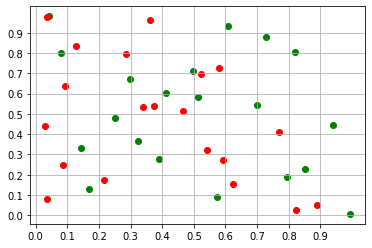

In [16]:
import lhsmdu
import numpy
l = lhsmdu.createRandomStandardUniformMatrix(2, 20) # Monte Carlo sampling
k = lhsmdu.sample(2, 20) # Latin Hypercube Sampling with multi-dimensional uniformity
k = np.array(k)
l = np.array(l)
import matplotlib.pyplot as plt 
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(numpy.arange(0,1,0.1))
ax.set_yticks(numpy.arange(0,1,0.1))
plt.scatter(k[0], k[1], color="g", label="LHS-MDU")
plt.scatter(l[0], l[1], color="r", label="MC")
plt.grid()
plt.show()
